In [1]:
%matplotlib notebook
import glob
import sys
import os
import warnings

import csv
import torch
import torch.nn as nn
import numpy as np
import random

from ipywidgets import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from FormatData import FormatData
from Utils import Utils, train, validate, predict, calc_scores
from Utils import replace_idx_to, predict_for_dataloader
from FCNet import FCNet
from FewLayerCNN import FewLayerCNN 
from MDataset import MDataset


warnings.filterwarnings("ignore")

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Split by maneuvers

In [5]:
filepaths = FormatData.get_IMU_file_names_from_dir(fdir=FormatData.get_labeled_files_dir())
fsplitdir = FormatData.get_labeled_files_dir() + "\SplitByManeuver\\"
# print(filepaths)

In [6]:
# Clear folder
for filep in glob.glob(fsplitdir + "*"):
    os.remove(filep)

min_maneuver_len = 10000000
max_maneuver_len = 0
maneuvers_quantity_by_types = np.zeros(15, dtype=int)
flabels = []
j = 0

for filep in filepaths:
    # read file
    out = FormatData.read_data_from_csv(file_name=filep, b_print_end_msg=False)
    _, out_parsed = FormatData.parse_csv_data(out, has_legend=True) 
    
    # get all parts with labels >= 0
    strlen = len(out_parsed[0]) - 1
    thislabel=out_parsed[0][strlen]
    max_ind = len(out_parsed)
    
    i = 0 # for flight file length
    #k = 0 # for maneuver length
    while i < max_ind:
        thislabel=out_parsed[i][strlen]
        # print(thislabel)
        # check whether were labeled or not
        if thislabel != "-1":
            mdata = []
            while i < max_ind and out_parsed[i][strlen] == thislabel:# and k < 5000:
                mdata.append(out_parsed[i])
                i = i + 1
                #k = k + 1
            # calc maneuvers quantity
            maneuvers_quantity_by_types[int(thislabel)] = maneuvers_quantity_by_types[int(thislabel)] + 1
            # check for length of smallest and longest data parts
            if min_maneuver_len > len(mdata):
                min_maneuver_len = len(mdata)
            if max_maneuver_len < len(mdata):
                max_maneuver_len = len(mdata)
                
            FormatData.write_data_to_csv(fsplitdir + f"M_{j}_label_{thislabel}" + ".csv", 
                                      FormatData.arrays_as_string_data(mdata, b_remove_last=False, labels=[]), 
                                      b_print_end_msg=False)
            k = 0
            j = j + 1
            flabels.append(int(thislabel))
            # print(thislabel)
        else:
            i = i + 1

FormatData.write_data_to_csv(file_name=fsplitdir + "L.csv", data_list=flabels, b_print_end_msg=True)

print(min_maneuver_len)
print(max_maneuver_len)
print(maneuvers_quantity_by_types)

Data saved!
100
56500
[ 18  31  79  85  25 251  25 162  30  87  55  10   5   2   4]


# Crop the borders

In [28]:
filepath = FormatData.get_file_names_from_dir(FormatData.get_labeled_files_dir() + "\SplitByManeuver\\")
fsplitdir = FormatData.get_labeled_files_dir() + "\SplitByManeuverAllInOne\\"

if not os.path.exists(fsplitdir):
    os.mkdir(fsplitdir)
# print(filepath)

In [29]:
str_match = [s for s in filepath if "L.csv" in s]
print(str_match)

filepath.remove(str_match[0])

['..\\FlightImuDataLabeled\\SplitByManeuver\\L.csv']


In [30]:
# run it just if you wish get another data
out = []

for filep in filepath:
    # read file
    out_csv = FormatData.read_data_from_csv(file_name=filep, b_print_end_msg=False)
    out_legend, out_parsed = FormatData.parse_csv_data(out_csv, 
                                                       legend_delimiter=',', 
                                                       data_delimiter=',',
                                                       has_legend=True) 
    
    strlen = len(out_parsed[0])
    max_ind = len(out_parsed)
    
    out.extend(out_parsed[max_ind//4:max_ind//4*3])
    
    
FormatData.write_data_to_csv(fsplitdir + f"All.csv", 
                             FormatData.arrays_as_string_data(out, 
                                                              labels=[],
                                                              b_remove_last=False), 
                             b_print_end_msg=False)

# Get the data

In [2]:
filepath = FormatData.get_file_names_from_dir(FormatData.get_labeled_files_dir() + "\SplitByManeuver\\")
fsplitdir = FormatData.get_labeled_files_dir() + "\SplitByManeuverAllInOne\\"

if not os.path.exists(fsplitdir):
    os.mkdir(fsplitdir)

In [3]:
from sklearn.model_selection import train_test_split

# read data from csv
all_data_csv = FormatData.read_data_from_csv(file_name=fsplitdir + f"All.csv", 
                                             b_print_end_msg=False)
# parse it to legend and string array
all_legend, all_parsed = FormatData.parse_csv_data(all_data_csv, 
                                                   legend_delimiter=',', 
                                                   data_delimiter=',',
                                                   has_legend=False) 

# convert everything to np arrays
all_data = FormatData.data_as_numpy_arrays(all_parsed)
# get classes
all_classes = all_data[:, -1]
# remove labels -1 and labels from data
all_data = np.delete(all_data, np.where(all_classes == -1), 
                        axis=0)
all_classes = np.delete(all_classes, np.where(all_classes == -1)).astype(int)
y = all_classes
# transform data (scaling with predefined values and add more features)
# and remove labels from data
all_data_tr = Utils.make_transformations(all_data[:, :-1])

# remove timestamp
X = all_data_tr[:, 1:]
# get unique classes
all_unique_classes = np.unique(all_classes)
print(f"All unique classes are {all_unique_classes}")

All unique classes are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [4]:
del all_data_csv
del all_legend
del all_parsed
del all_data
del all_classes
del all_data_tr

In [5]:
# reassign classes
# y = replace_idx_to(y, old_idx=7, new_idx=5)
# y = replace_idx_to(y, old_idx=8, new_idx=5)
y = replace_idx_to(y, old_idx=6, new_idx=4)
y = replace_idx_to(y, old_idx=9, new_idx=7)
y = replace_idx_to(y, old_idx=10, new_idx=8)
y = replace_idx_to(y, old_idx=11, new_idx=7)
y = replace_idx_to(y, old_idx=12, new_idx=8)
y = replace_idx_to(y, old_idx=13, new_idx=9)
y = replace_idx_to(y, old_idx=14, new_idx=9)

# get unique classes
all_unique_classes = np.unique(y)
print(f"All unique classes are {all_unique_classes}")

All unique classes are [0 1 2 3 4 5 7 8 9]


# Make patches

In [6]:
import numpy as np

def make_patches_split_data(data: np.array, labels: np.array, patch_len=1):
    out = []
    out_labels = []
    for i in range(len(data) - patch_len + 1):
        tmp = data[i:i+patch_len].flatten()
        # if all of lines are from this type of maneuver
        if all([labels[i] == labels[j] for j in range(i, i+patch_len)]):
            out.append(list(tmp))
            out_labels.append(labels[i+patch_len-1])
    return np.array(out), np.array(out_labels)

In [7]:
# make patches
patch_length = 50

Xp, yp = make_patches_split_data(X, y, patch_len=patch_length)

In [8]:
num_labels = []
for i in range(len(all_unique_classes)):
    num_labels.append(len(np.where(yp == all_unique_classes[i])[0]))
print(f"Quantity labels are {num_labels}")

Quantity labels are [6441, 45857, 71855, 130548, 50801, 301326, 130017, 71769, 10798]


In [9]:
# # it is  for creating the balanced dataset
# # not used

# torch.manual_seed(42)
# idxs = torch.randperm(len(Xp))

# Xp = Xp[idxs]
# yp = yp[idxs]

# Xp2 = Xp
# yp2 = yp

# max_q_for_label = min(num_labels)

# for i in all_unique_classes:
#     while len(np.where(yp2 == i)[0]) < max_q_for_label:
#         Xp2 = np.append(Xp2, Xp2[(np.where(y == i)[0])], axis=0)
#         yp2 = np.append(yp2, yp2[(np.where(y == i)[0])], axis=0)

# X_balanced = []
# y_balanced = []
# for i in all_unique_classes:
#     if len(X_balanced) < 1:
#         X_balanced = Xp2[(np.where(yp2 == i)[0])[0:max_q_for_label]]
#         y_balanced = yp2[(np.where(yp2 == i)[0])[0:max_q_for_label]]
#     else:
#         X_balanced = np.append(X_balanced, Xp2[(np.where(yp2 == i)[0])[0:max_q_for_label]], axis=0)
#         y_balanced = np.append(y_balanced, yp2[(np.where(yp2 == i)[0])[0:max_q_for_label]], axis=0)
    
# num_labels = []
# for i in range(len(all_unique_classes)):
#     num_labels.append(len(np.where(y_balanced == all_unique_classes[i])[0]))
# print(f"Quantity labels are {num_labels}")

# # split train-test
# X_train, X_test, y_train, y_test = train_test_split(X_balanced, 
#                                                     y_balanced, 
#                                                     test_size=0.2, 
#                                                     random_state=42, 
#                                                     shuffle=True)

# Train-val-test split

In [10]:
# split train-test
X_train, X_test, y_train, y_test = train_test_split(Xp, 
                                                    yp, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=yp)

In [11]:
num_labels = []
for i in all_unique_classes:
    num_labels.append(len(np.where(y_test == i)[0]))
print(f"Quantity labels are {num_labels}")

Quantity labels are [1288, 9171, 14371, 26110, 10160, 60265, 26004, 14354, 2160]


In [12]:
print(f"Train X shape: {X_train.shape}, train y shape {y_train.shape}")
print(f"Test X shape: {X_test.shape}, test y shape {y_test.shape}")

Train X shape: (655529, 400), train y shape (655529,)
Test X shape: (163883, 400), test y shape (163883,)


# Standardize and make dataloaders

In [22]:
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler,  RobustScaler
import random

batch_size = 32

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

train_dataset = MDataset(X_train_scaled, y_train)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [23]:
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(Xp)

mdataset = MDataset(X_scaled, yp)
test_dataset = MDataset(X_test_scaled, y_test)

alldataloader = DataLoader(mdataset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [15]:
# X_balanced_scaled = scaler.transform(X_balanced)
# # create balanced datasets
# bal_dataset = MDataset(X_balanced_scaled, y_balanced)

# Initialize NNs

In [30]:
fcnet_best_params = {'layers': 13, 
                     'hid_layer_dim': 177, 
                     'lr': 9.233218914635897e-05, 
                     'optim': torch.optim.RMSprop, 
                     'activation': torch.nn.modules.activation.ReLU}

In [31]:
net = FCNet(seq_len=X_train.shape[1],
            activation_func=fcnet_best_params['activation'], 
            n_layers=fcnet_best_params['layers'], 
            hid_layer_dim=fcnet_best_params['hid_layer_dim']
           ).to(device)
optimizer = fcnet_best_params['optim'](net.parameters(), lr=fcnet_best_params['lr'])

accs = []
losses = []
loss_func = nn.CrossEntropyLoss().to(device)

# train(net, 
#       nn.CrossEntropyLoss().to(device), 
#       optimizer, 
#       epochs=250, 
#       _trainloader=trainloader, 
#       _valloader=testloader,
#       device=device)

In [18]:
cnn_best_params = {'layers': 4,
                   'kernel_sz': 5,
                   'lr': 0.0018692709573065612,
                   'optim': torch.optim.Adam,
                   'activation': torch.nn.modules.activation.Tanh}

In [19]:
net = FewLayerCNN(conv_layer_nums=cnn_best_params['layers'],
                  seq_len=X_train.shape[1],
                  activation_func=cnn_best_params['activation'], 
                  kernel_size=cnn_best_params['kernel_sz']*2+1,
                 ).to(device)
optimizer = cnn_best_params['optim'](net.parameters(), lr=cnn_best_params['lr'])

accs = []
losses = []
loss_func = nn.CrossEntropyLoss().to(device)

# train(net, 
#       nn.CrossEntropyLoss().to(device), 
#       optimizer, 
#       epochs=250, 
#       _trainloader=trainloader, 
#       _valloader=testloader,
#       device=device)

# Train the NN

In [32]:
from tqdm import tqdm
import torch.nn as nn

losses = []
accs = []

for i in tqdm(range(20)):
    acc = train(net, 
                loss_func, 
                optimizer, 
                epochs=1, 
                _trainloader=trainloader, 
                _valloader=testloader,
                device=device)
    accs.append(acc)
    net.eval()
    
    all_predicted = torch.tensor([])
    with torch.no_grad():
        for objs, labels in testloader: # get batch
            outputs = net(objs.to(device))
            all_predicted = torch.cat((all_predicted, outputs.to('cpu')), axis=0)
            
    losses.append(loss_func(all_predicted.to(device), 
                            torch.tensor(testloader.dataset.labels, dtype=int).to(device)).cpu().item())
#     # early stopping for 
#     stop_for_losses = 8
#     if len(losses) > stop_for_losses and all([losses[-1] > loss for loss in losses[-stop_for_losses:-1]]):
#         break
        

    print(accs[-1])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [30:21<00:00, 91.06s/it]

0.9906884789758548


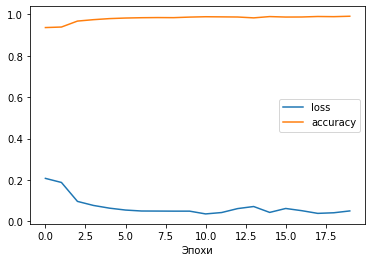

In [43]:
%matplotlib inline

# plt.plot([loss.cpu().item() for loss in losses])
plt.plot(losses, label='loss')
plt.plot(accs, label='accuracy')
plt.xlabel("Эпохи")
# plt.ylabel("Gold")
plt.legend()
plt.savefig('loss-acc.png', dpi=600, format='png')

In [34]:
from sklearn.metrics import jaccard_score
from Utils import predict_for_dataloader

y_pred, y_real = predict_for_dataloader(net, testloader, device=device)

print(jaccard_score(y_real, y_pred, average=None))

[0.88795088 0.97415718 0.97622493 0.98418519 0.9475     0.98731031
 0.         0.98783613 0.99396797 0.92092617]


# Compare the classifiers

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler,  RobustScaler
from torch.utils.data import DataLoader

import numpy as np
import random
import time
import torch.nn as nn


sc_names = [
            'StandardScaler',
            'MinMaxScaler',
            'MaxAbsScaler',
            'RobustScaler']
scalers = [
           StandardScaler,
           MinMaxScaler,
           MaxAbsScaler,
           RobustScaler]

clf_names = [
    "Decision Tree",
    "Random Forest",
    "Neural Net (MLP)",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "Nearest Neighbors",
#     "Gaussian Process",
#     "Linear SVM",
#     "RBF SVM",
]

clf_nn_names = [
    'FCNet',
    'CNN'
]

def check_classifiers_with_scalers(_x_train, _x_test, _y_train, _y_test):
    _ascores = []
    _tscores = []
    _prs = []
    _res = []
    _f1s = []
    _jas = []
    _ja_ms = []
    _time = []
    
    for scaler_n, scaler_t in zip(sc_names, scalers):
        print(f" ")
        print(f"For scaler {scaler_n}")
        print(f" ")
        scaler = scaler_t()
        _X_train_scaled = scaler.fit_transform(_x_train)

        _X_test_scaled = scaler.transform(_x_test)
    
        classifiers = [
            DecisionTreeClassifier(max_depth=12),
            RandomForestClassifier(max_depth=12, n_estimators=15, max_features=5),
            MLPClassifier(alpha=0.00014, max_iter=2800, random_state=42, activation='tanh'),
            AdaBoostClassifier(),
            GaussianNB(),
            QuadraticDiscriminantAnalysis(),
            KNeighborsClassifier(6),
#             GaussianProcessClassifier(1.0 * RBF(1.0)),
#             SVC(kernel="linear", C=0.025),
#             SVC(gamma=2, C=1),
        ]

        # iterate over classifiers
        for name, clf in zip(clf_names, classifiers):
            # print(name)

            start = time.time()
            clf.fit(_X_train_scaled, _y_train)
            ftime = time.time() - start
            test_score = clf.score(_X_test_scaled, _y_test)
            print(f"For {name} test score is {test_score:.5f}")
    
            _y_pred = clf.predict(_X_test_scaled).tolist()
            _y_all = _y_test
            _a, _pr, _re, _f1, _ja, _ja_m = calc_scores(_y_pred=_y_pred, _y_real=_y_all)
            print(f"Full accuracy is {_a:.5f}, precision is {_pr:.5f}, recall is {_re:.5f},",
                  f"f1 is {_f1:.5f}, ja is {_ja:.5f}, ja_m is {_ja_m:.5f}\nFitting time is {ftime:.5f}")
            
            _tscores.append(test_score)
            _ascores.append(_a)
            _prs.append(_pr)
            _res.append(_re)
            _f1s.append(_f1)
            _jas.append(_ja)
            _ja_ms.append(_ja_m)
            _time.append(ftime)

        # create balanced datasets
        train_dataset = MDataset(_X_train_scaled, y_train)
        test_dataset = MDataset(_X_test_scaled, y_test)

        trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

        
        nn_classifiers = [
            FCNet(seq_len=X_train.shape[1],
                  activation_func=fcnet_best_params['activation'], 
                  n_layers=fcnet_best_params['layers'], 
                  hid_layer_dim=fcnet_best_params['hid_layer_dim']
                 ).to(device),
            FewLayerCNN(conv_layer_nums=cnn_best_params['layers'],
                  seq_len=X_train.shape[1],
                  activation_func=cnn_best_params['activation'], 
                  kernel_size=cnn_best_params['kernel_sz']*2+1,
                 ).to(device)
        ]
    
        nn_optimizers = [
            fcnet_best_params['optim'],
            cnn_best_params['optim'],
        ]
        
        nn_lr = [
            fcnet_best_params['lr'],
            cnn_best_params['lr'],
        ]
        
        nn_epochs = [
            20,
            30
        ]
        
        for name, clf, optim, lr, n_epoch in zip(clf_nn_names, 
                                        nn_classifiers, 
                                        nn_optimizers, 
                                        nn_lr,
                                        nn_epochs):
            optimizer = optim(clf.parameters(), lr=lr)
            
            start = time.time()
            test_score = train(clf, 
                               nn.CrossEntropyLoss().to(device), 
                               optimizer, 
                               epochs=n_epoch, 
                               _trainloader=trainloader, 
                               _valloader=testloader,
                               device=device
                              )
            ftime = time.time() - start
            print(f"For {name} test score is {test_score:.5f}")
            
            y_pred, y_real = predict_for_dataloader(clf, testloader, device=device)
            _a, _pr, _re, _f1, _ja, _ja_m = calc_scores(_y_pred=y_pred, _y_real=y_real)
            print(f"Accuracy is {_a:.5f}, precision is {_pr:.5f}, recall is {_re:.5f},",
                  f"f1 is {_f1:.5f}, ja is {_ja:.5f}, ja_m is {_ja_m:.5f}\nFitting time is {ftime:.5f}")
            
            _tscores.append(test_score)
            _ascores.append(_a)
            _prs.append(_pr)
            _res.append(_re)
            _f1s.append(_f1)
            _jas.append(_ja)
            _ja_ms.append(_ja_m)
            _time.append(ftime)
            
    return _ascores, _tscores, _prs, _res, _f1s, _jas, _ja_ms, _time

Здесь в выводе сохранены части значений метрик, полученных при расчёте. Для проверки расчёта достаточно запустить лишь один блок

In [23]:
ascores, tscores, prs, res, f1s, jas, ja_ms, time_ = check_classifiers_with_scalers(_x_train=X_train, 
                                                                                    _x_test=X_test, 
                                                                                    _y_train=y_train, 
                                                                                    _y_test=y_test)

 
For scaler RobustScaler
 
For FCNet test score is 0.99062
Accuracy is 0.99062, precision is 0.99069, recall is 0.99062, f1 is 0.99059, ja is 0.98148, ja_m is 0.88569
Fitting time is 2791.23574
For CNN test score is 0.97798
Accuracy is 0.97798, precision is 0.97793, recall is 0.97798, f1 is 0.97789, ja is 0.95713, ja_m is 0.84267
Fitting time is 1710.99042


In [20]:
ascores, tscores, prs, res, f1s, jas, ja_ms, time_ = check_classifiers_with_scalers(_x_train=X_train, 
                                                                                    _x_test=X_test, 
                                                                                    _y_train=y_train, 
                                                                                    _y_test=y_test)

 
For scaler RobustScaler
 
For Nearest Neighbors test score is 0.90570
Full accuracy is 0.90570, precision is 0.91726, recall is 0.90570, f1 is 0.90546, ja is 0.83208, ja_m is 0.61765
Fitting time is 0.30296


NameError: name 'cnn_best_params' is not defined

In [ ]:
ascores, tscores, prs, res, f1s, jas, ja_ms, time_ = check_classifiers_with_scalers(_x_train=X_train, 
                                                                                    _x_test=X_test, 
                                                                                    _y_train=y_train, 
                                                                                    _y_test=y_test)

 
For scaler StandardScaler
 
For Decision Tree test score is 0.73117
Full accuracy is 0.73117, precision is 0.74421, recall is 0.73117, f1 is 0.72304, ja is 0.58294, ja_m is 0.18819
Fitting time is 274.97634
For Random Forest test score is 0.76490
Full accuracy is 0.76490, precision is 0.80314, recall is 0.76490, f1 is 0.74910, ja is 0.62286, ja_m is 0.13902
Fitting time is 41.47176
For Neural Net (MLP) test score is 0.95860
Full accuracy is 0.95860, precision is 0.95861, recall is 0.95860, f1 is 0.95857, ja is 0.92212, ja_m is 0.66575
Fitting time is 727.45916
For AdaBoost test score is 0.34955
Full accuracy is 0.34955, precision is 0.36439, recall is 0.34955, f1 is 0.33101, ja is 0.20945, ja_m is 0.00078
Fitting time is 1396.86966
For Naive Bayes test score is 0.40587
Full accuracy is 0.40587, precision is 0.54156, recall is 0.40587, f1 is 0.42151, ja is 0.27471, ja_m is 0.04970
Fitting time is 3.06982
For QDA test score is 0.57961
Full accuracy is 0.57961, precision is 0.76581, rec

На всякий случай сохранены вместе результаты того, что получилось 

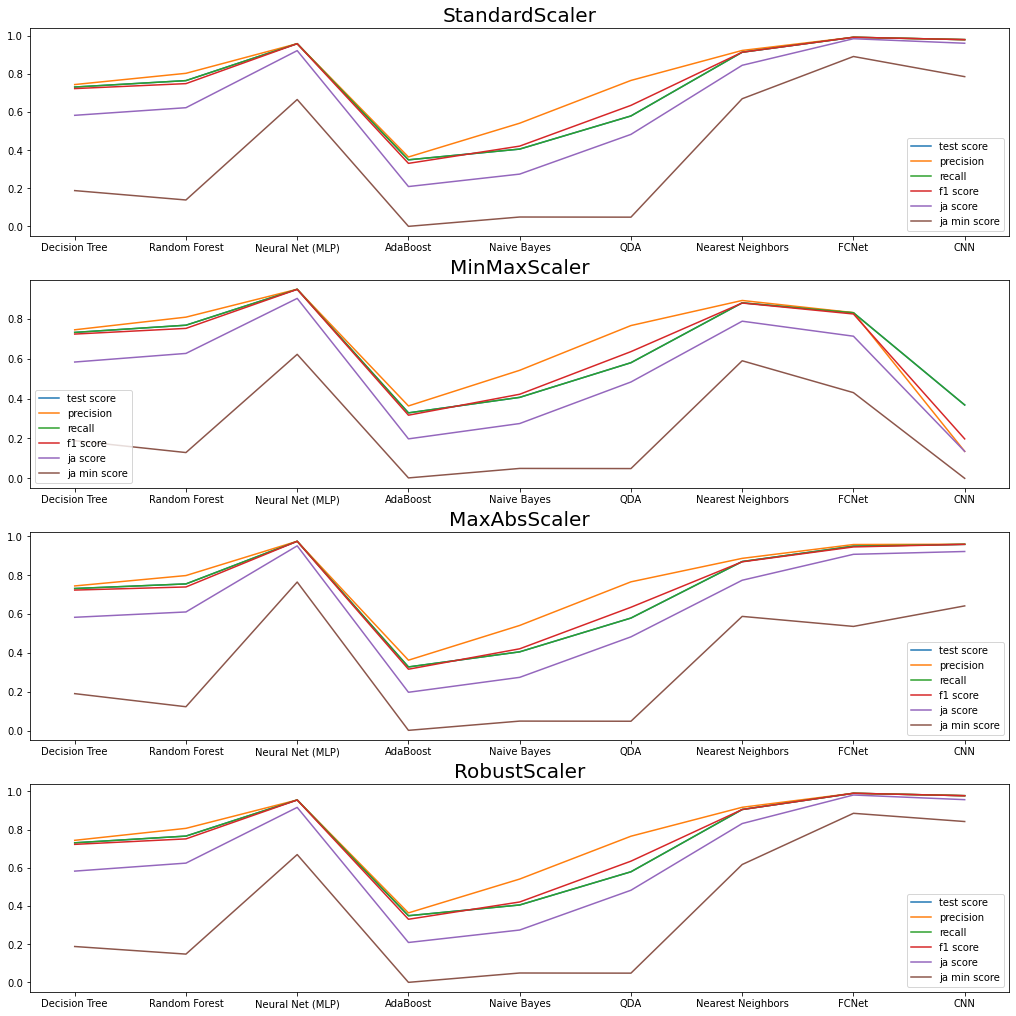

In [32]:
%matplotlib inline

all_clf_names = [*clf_names, *clf_nn_names]

sc_len = len(scalers)
clf_len = len(all_clf_names)
fig, ax = plt.subplots(4, 1, figsize=(14, 14), constrained_layout=True)
for i in range(sc_len):
    # f.add_subplot(4, 1, i+1)    
    ax[i].plot(tscores[clf_len*i:clf_len*(i+1)], label='test score')
    ax[i].plot(prs[clf_len*i:clf_len*(i+1)], label='precision')
    ax[i].plot(res[clf_len*i:clf_len*(i+1)], label='recall')
    ax[i].plot(f1s[clf_len*i:clf_len*(i+1)], label='f1 score')
    ax[i].plot(jas[clf_len*i:clf_len*(i+1)], label='ja score')
    ax[i].plot(ja_ms[clf_len*i:clf_len*(i+1)], label='ja min score')
    ax[i].set_title(sc_names[i], size=20)
#     ax[i].set_xlabel("Classifiers", size=16)
    ax[i].set_ylabel("", size=20)
    ax[i].set_xticks(np.arange(len(all_clf_names)), all_clf_names)
    ax[i].legend()

plt.savefig('results.png', dpi=600, format='png')

In [33]:
idx = np.argmax(tscores)
print(f"For accuracy on val dataset the best classifier is \n{all_clf_names[idx%clf_len]} with {sc_names[idx//clf_len]}\n")
idx = np.argmax(prs)
print(f"For precision on val dataset the best classifier is \n{all_clf_names[idx%clf_len]} with {sc_names[idx//clf_len]}\n")
idx = np.argmax(res)
print(f"For recall on val dataset the best classifier is \n{all_clf_names[idx%clf_len]} with {sc_names[idx//clf_len]}\n")
idx = np.argmax(f1s)
print(f"For f1 score on val dataset the best classifier is \n{all_clf_names[idx%clf_len]} with {sc_names[idx//clf_len]}\n")
idx = np.argmax(jas)
print(f"For jaccard avg score on val dataset the best classifier is",
      f"\n{all_clf_names[idx%clf_len]} with {sc_names[idx//clf_len]}\n")
idx = np.argmax(ja_ms)
print(f"For jaccard min score on val dataset the best classifier is",
      f"\n{all_clf_names[idx%clf_len]} with {sc_names[idx//clf_len]}\n")

For accuracy on val dataset the best classifier is 
FCNet with StandardScaler

For precision on val dataset the best classifier is 
FCNet with StandardScaler

For recall on val dataset the best classifier is 
FCNet with StandardScaler

For f1 score on val dataset the best classifier is 
FCNet with StandardScaler

For jaccard avg score on val dataset the best classifier is 
FCNet with StandardScaler

For jaccard min score on val dataset the best classifier is 
FCNet with StandardScaler



## Посмотреть на результат для треков

In [35]:
track_paths = FormatData.get_IMU_file_names_from_dir(FormatData.get_labeled_files_dir())
print(track_paths)

['..\\FlightImuDataLabeled\\IMU_2021_06_27_19_40_10.csv', '..\\FlightImuDataLabeled\\IMU_2021_07_03_20_56_10.csv', '..\\FlightImuDataLabeled\\IMU_2021_07_18_18_14_08.csv', '..\\FlightImuDataLabeled\\IMU_2021_08_15_20_14_39.csv', '..\\FlightImuDataLabeled\\IMU_2021_08_29_15_52_21.csv', '..\\FlightImuDataLabeled\\IMU_2021_08_29_16_15_35.csv', '..\\FlightImuDataLabeled\\IMU_2021_08_29_16_41_14.csv', '..\\FlightImuDataLabeled\\IMU_2021_10_02_15_57_23.csv', '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_40.csv', '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42_0.csv', '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42_1.csv', '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42_2.csv', '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42_3.csv', '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42_4.csv', '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42_5.csv', '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42_6.csv', '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42_7.csv', '..\\FlightImu

На одном треке

In [47]:
# get one track

out_csv = FormatData.read_data_from_csv(file_name=track_paths[2], # '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42.csv',
                                        b_print_end_msg=False)
out_legend, out_parsed = FormatData.parse_csv_data(out_csv, 
                                                   legend_delimiter=',', 
                                                   data_delimiter=',',
                                                   has_legend=True)

data = FormatData.data_as_numpy_arrays(out_parsed)

# get labels
labels = torch.tensor((data[:,-1:]).flatten(), dtype=int)
# replacing indices as for train data
labels = replace_idx_to(labels, old_idx=6, new_idx=4)
labels = replace_idx_to(labels, old_idx=9, new_idx=7)
labels = replace_idx_to(labels, old_idx=10, new_idx=8)
labels = replace_idx_to(labels, old_idx=11, new_idx=7)
labels = replace_idx_to(labels, old_idx=12, new_idx=8)
labels = replace_idx_to(labels, old_idx=13, new_idx=9)
labels = replace_idx_to(labels, old_idx=14, new_idx=9)

# transform data and remove timestamp
data = Utils.make_transformations(data[:,:-1])
data = torch.tensor(data[:,1:], dtype=torch.float)
# making patches
data, labels = make_patches_split_data(data, labels, patch_len=patch_length)
# scaling the data
data_scaled = torch.tensor(scaler.transform(data), dtype=torch.float)
# predict 
# y_pred = torch.tensor(net.predict(data_scaled, device=device), dtype=int)

track_dataset = MDataset(data_scaled, labels)
trackloader = DataLoader(track_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
y_pred, y_real = predict_for_dataloader(net, trackloader, device=device)

# plt.plot(labels)
# plt.plot(y_pred)

Посмотреть на всех треках

In [ ]:
# get all files
all_parsed = []

for filename in track_paths:
    out_csv = FormatData.read_data_from_csv(file_name=filename, # '..\\FlightImuDataLabeled\\IMU_2022_05_14_18_13_42.csv',
                                            b_print_end_msg=False)
    out_legend, out_parsed = FormatData.parse_csv_data(out_csv, 
                                                       legend_delimiter=',', 
                                                       data_delimiter=',',
                                                       has_legend=True)
    all_parsed.extend(out_parsed)

data = FormatData.data_as_numpy_arrays(all_parsed)

# get labels
labels = torch.tensor((data[:,-1:]).flatten(), dtype=int)
# replacing indices as for train data
labels = replace_idx_to(labels, old_idx=6, new_idx=4)
labels = replace_idx_to(labels, old_idx=9, new_idx=7)
labels = replace_idx_to(labels, old_idx=10, new_idx=8)
labels = replace_idx_to(labels, old_idx=11, new_idx=7)
labels = replace_idx_to(labels, old_idx=12, new_idx=8)
labels = replace_idx_to(labels, old_idx=13, new_idx=9)
labels = replace_idx_to(labels, old_idx=14, new_idx=9)

# transform data and remove timestamp
data = Utils.make_transformations(data[:,:-1])
data = torch.tensor(data[:,1:], dtype=torch.float)
# making patches
data, labels = make_patches_split_data(data, labels, patch_len=patch_length)
# scaling the data
data_scaled = torch.tensor(scaler.transform(data), dtype=torch.float)
# predict 
# y_pred = torch.tensor(net.predict(data_scaled, device=device), dtype=int)

track_dataset = MDataset(data_scaled, labels)
trackloader = DataLoader(track_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
y_pred, y_real = predict_for_dataloader(net, trackloader, device=device)

# plt.plot(labels)
# plt.plot(y_pred)

# Результат предсказания

In [37]:
print(f"All unique classes are {np.unique(y_real)}")

All unique classes are [0. 2. 3. 4. 5. 7. 8.]


In [38]:
print(f"All unique classes are {np.unique(y_pred)}")

All unique classes are [0. 1. 2. 3. 4. 5. 7. 8. 9.]


In [48]:
_a, _pr, _re, _f1, _ja, _ja_m = calc_scores(_y_pred=y_pred, _y_real=y_real)
print(f"Accuracy is {_a:.5f}, precision is {_pr:.5f}, recall is {_re:.5f},",
      f"f1 is {_f1:.5f}, ja is {_ja:.5f}, ja_m is {_ja_m:.5f}")

Accuracy is 0.86977, precision is 0.90054, recall is 0.86977, f1 is 0.87843, ja is 0.78518, ja_m is 0.00000


In [49]:
from sklearn.metrics import jaccard_score

jaccard_score(y_real, y_pred, average=None)

array([0.72898799, 0.        , 0.83416318, 0.77186717, 0.68550703,
       0.79477361, 0.84599038, 0.63579188, 0.        ])

<IPython.core.display.Javascript object>


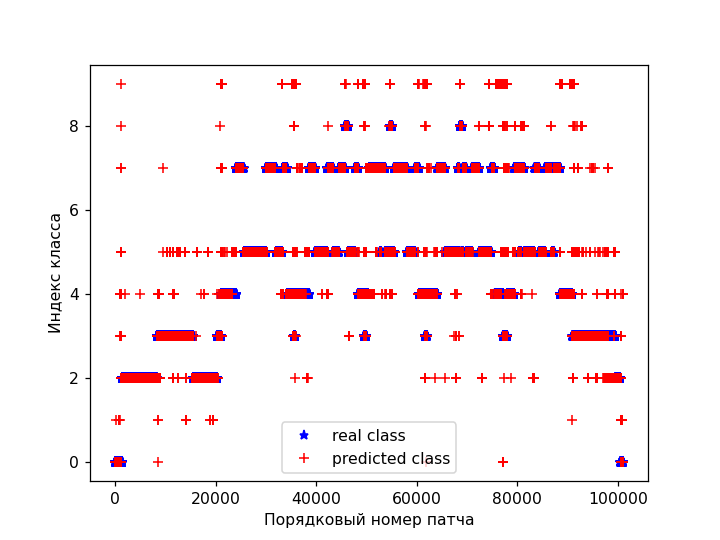

In [51]:
%matplotlib notebook

plt.plot(y_real, 'b*', label='real class')
plt.plot(y_pred, 'r+', label='predicted class')
plt.xlabel("Порядковый номер патча")
plt.ylabel("Индекс класса")
plt.legend()
plt.savefig('test_on_track.png', dpi=600, format='png')

# Check parameters with optuna

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                 y_train, 
                                                 test_size=0.2, 
                                                 random_state=42, 
                                                 shuffle=True,
                                                 stratify=y_train)

X_val_scaled = scaler.transform(X_val)
val_dataset = MDataset(X_val_scaled, y_val)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [21]:
scaler_this = RobustScaler()
X_train_scaled = scaler_this.fit_transform(X_train)
X_val_scaled = scaler_this.transform(X_val)

DecisionTreeClassifier

In [ ]:
import optuna
from sklearn.metrics import jaccard_score

def objective(trial):
    max_depth_trial = trial.suggest_int('max_depth', 3, 30) 
    
    clf = DecisionTreeClassifier(max_depth=max_depth_trial)
    clf.fit(X_train_scaled, y_train)
    
    y_pred = clf.predict(X_val_scaled).tolist()

    val = min(jaccard_score(y_val, y_pred, average=None))
    
    return -val

study = optuna.create_study()
study.optimize(objective, timeout=600)

In [ ]:
study.best_params # {'max_depth': 28}

RandomForestClassifier

In [ ]:
import optuna
from sklearn.metrics import jaccard_score

def objective(trial):
    max_depth_trial = trial.suggest_int('max_depth', 3, 12) 
    n_estimators_trial = trial.suggest_int('n_estimators', 3, 16) 
    max_features_trial = trial.suggest_int('max_features', 1, 8)
    
    clf = RandomForestClassifier(max_depth=max_depth_trial, 
                                 n_estimators=n_estimators_trial, 
                                 max_features=max_features_trial)
    clf.fit(X_train_scaled, y_train)
    
    y_pred = clf.predict(X_val_scaled).tolist()

    val = min(jaccard_score(y_val, y_pred, average=None))
    
    return -val

study = optuna.create_study()
study.optimize(objective, timeout=600)

In [ ]:
study.best_params # 

MLPClassifier

In [ ]:
import optuna
from sklearn.metrics import jaccard_score

def objective(trial):
    alpha_trial = trial.suggest_loguniform('alpha', 1e-6, 1e0) 
    max_iter_trial = trial.suggest_int('max_iter', 100, 4000) 
    activation_trial = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']) 
    
    clf = MLPClassifier(alpha=alpha_trial, 
                        max_iter=max_iter_trial, 
                        activation=activation_trial,
                        random_state=42)
    clf.fit(X_train_scaled, y_train)
    
    y_pred = clf.predict(X_val_scaled).tolist()

    val = min(jaccard_score(y_val, y_pred, average=None))
    
    return -val

study = optuna.create_study()
study.optimize(objective, timeout=1200)

In [ ]:
study.best_params # {'alpha': 1.8504468931049676e-05, 
# 'max_iter': 3271, 'activation': 'relu'}

KNeighborsClassifier

In [ ]:
import optuna
from sklearn.metrics import jaccard_score

def objective(trial):
    nn_trial = trial.suggest_int('nn', 2, 30)
    
    clf = KNeighborsClassifier(nn_trial)
    clf.fit(X_train_scaled, y_train)
    
    y_pred = clf.predict(X_val_scaled).tolist()

    val = min(jaccard_score(y_val, y_pred, average=None))
    
    return -val

study = optuna.create_study()
study.optimize(objective, timeout=600)

In [ ]:
study.best_params # 

FewLayerCNN

In [ ]:
import optuna
from sklearn.metrics import jaccard_score

accs = []

def objective(trial):
    layers_trial = trial.suggest_int('layers', 0, 10)
    lr_trial = trial.suggest_loguniform('lr', 1e-6, 1e0)
    optim_trial = trial.suggest_categorical('optim', [torch.optim.SGD, 
                                                      torch.optim.Adam, 
                                                      torch.optim.RMSprop]) 
    activation_trial = trial.suggest_categorical('activation', [nn.ReLU, 
                                                                nn.Tanh, 
                                                                nn.Sigmoid]) 
    
    accs = []
    
    net = FewLayerCNN(layers_trial, 
                      seq_len=X_train.shape[1],
                      activation_func=activation_trial
                     ).to(device)
    optimizer = optim_trial(net.parameters(), lr=lr_trial)
    
    acc = train(net, 
           nn.CrossEntropyLoss().to(device), 
           optimizer, 
           epochs=35, 
           _trainloader=trainloader, 
           _valloader=valloader,
           device=device)

    y_pred = torch.tensor(net.predict(torch.tensor(X_val_scaled), device=device), dtype=int)
    val = min(jaccard_score(y_val, y_pred, average=None))
    
    return -val

study = optuna.create_study()
study.optimize(objective, timeout=5000)

In [ ]:
study.best_params

FCNet

In [16]:
import optuna
from sklearn.metrics import jaccard_score

accs = []

def objective(trial):
    layers_trial = trial.suggest_int('layers', 1, 25)
    hid_layer_dim_trial = trial.suggest_int('hid_layer_dim', 5, 300)
    lr_trial = trial.suggest_loguniform('lr', 1e-6, 1e0)
    optim_trial = trial.suggest_categorical('optim', [torch.optim.SGD, 
                                                      torch.optim.Adam, 
                                                      torch.optim.RMSprop]) 
    activation_trial = trial.suggest_categorical('activation', [nn.ReLU, 
                                                                nn.Tanh, 
                                                                nn.Sigmoid]) 
    
    net = FCNet(seq_len=X_train.shape[1],
                activation_func=activation_trial, 
                n_layers=layers_trial, 
                hid_layer_dim=hid_layer_dim_trial).to(device)
    optimizer = optim_trial(net.parameters(), lr=lr_trial)
    
    acc = train(net, 
           nn.CrossEntropyLoss().to(device), 
           optimizer, 
           epochs=30, 
           _trainloader=trainloader, 
           _valloader=valloader,
           device=device)

    y_pred = torch.tensor(net.predict(torch.tensor(X_val_scaled), device=device), dtype=int)
    val = min(jaccard_score(y_val, y_pred, average=None))
    
    return -val

study = optuna.create_study()
study.optimize(objective, timeout=30000)

[I 2022-06-20 21:51:14,248] A new study created in memory with name: no-name-5d7ea425-d33d-4bf1-bb23-2c51a4af5bad
[I 2022-06-20 22:29:00,831] Trial 0 finished with value: -0.0 and parameters: {'layers': 8, 'hid_layer_dim': 270, 'lr': 0.011495536447865686, 'optim': <class 'torch.optim.rmsprop.RMSprop'>, 'activation': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 0 with value: -0.0.
[I 2022-06-20 23:17:34,822] Trial 1 finished with value: -0.7920433996383364 and parameters: {'layers': 14, 'hid_layer_dim': 228, 'lr': 0.00030231121520474046, 'optim': <class 'torch.optim.adam.Adam'>, 'activation': <class 'torch.nn.modules.activation.Tanh'>}. Best is trial 1 with value: -0.7920433996383364.


In [ ]:
study.best_params